In [626]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns


In [603]:
path = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/%s/Results.txt'
path_annotation = '/home/juan/Desktop/juan/bio/mirna_mite/data/introns.gff3'
path_annotation_promoters = '/home/juan/Desktop/juan/bio/mirna_mite/data/promoters.gff3'
path_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv'
path_mirna_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.fasta'
path_mirna_mature = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.mature.csv'
path_res_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta'
experiments = ['mrcv_mites','mrcv_all','sun_all','sun_mites']
path_genome = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.dna.toplevel.fa'
path_blast_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/blast_mites.csv'
path_mirbase = '/home/juan/Desktop/juan/bio/mirna_mite/data/mature.fa'

In [534]:
#Load shortstack results
dfs = {}
for experiment in experiments:
    experiment_path = path % (experiment,)
    df = pd.read_csv(experiment_path, sep='\t')
    df['Name'] = experiment + '_' + df['Name']
    print('Experiment:', experiment)
    print('All results:',len(df.index))
    df = df[df.MIRNA == 'Y']
    print('Only miRNAs:',len(df.index))
    df = df[df.Reads > 20]
    print('Only miRNAs +20 reads:',len(df.index))
    print('*' * 10)
    dfs[experiment] = df

Experiment: mrcv_mites
All results: 1211339
Only miRNAs: 39
Only miRNAs +20 reads: 22
**********
Experiment: mrcv_all
All results: 38532
Only miRNAs: 135
Only miRNAs +20 reads: 135
**********
Experiment: sun_all
All results: 157492
Only miRNAs: 154
Only miRNAs +20 reads: 154
**********
Experiment: sun_mites
All results: 1211339
Only miRNAs: 24
Only miRNAs +20 reads: 12
**********


In [535]:
dfs = [ v for v in dfs.values() ]

In [536]:
df = pd.concat(dfs)

In [537]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24
125231,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,21,Y,-1.0,0,4,2,38,1,0,0
171085,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,22,Y,-1.0,4,1,1,39,89,63,1


In [538]:
df['seqname'] = df['#Locus'].str.split(':').str[0]
df['position'] = df['#Locus'].str.split(':').str[1]
df['start'] = df.position.str.split('-').str[0].astype(int)
df['end'] = df.position.str.split('-').str[1].astype(int)
df['duplicated'] = 0
df['seqlen'] = df.end - df.start
df['overlap_len'] = df.seqlen  * 0.1
df['overlap_len'] = df.overlap_len.astype(int)
df['start_overlap'] = df.start + df.overlap_len
df['end_overlap'] = df.end - df.overlap_len

In [539]:
print(len(df.index))

323


In [540]:
df[df.index.isin(['876749','876750','876751','27433'])]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,24,seqname,position,start,end,duplicated,seqlen,overlap_len,start_overlap,end_overlap
876749,6A:23496429-23496595,mrcv_mites_MITE_T_64052|chr7B|176002823|176003...,167,111,0.871,18,0.045,-,UUAGAGGUUUCAAUACGGACU,82,...,4,6A,23496429-23496595,23496429,23496595,0,166,16,23496445,23496579
876750,6A:23496449-23496574,mrcv_mites_MITE_T_70309|chr6D|429354379|429354...,126,108,0.848,18,0.028,-,UUAGAGGUUUCAAUACGGACU,82,...,4,6A,23496449-23496574,23496449,23496574,0,125,12,23496461,23496562
876751,6A:23496458-23496565,mrcv_mites_MITE_T_95046|chr2B|521974897|521975...,108,107,0.840,18,0.019,-,UUAGAGGUUUCAAUACGGACU,82,...,4,6A,23496458-23496565,23496458,23496565,0,107,10,23496468,23496555
27433,6A:23496419-23496608,mrcv_all_Cluster_27434,190,111,0.871,18,0.045,-,UUAGAGGUUUCAAUACGGACU,82,...,4,6A,23496419-23496608,23496419,23496608,0,189,18,23496437,23496590


In [541]:
duplicated = []
for k,v in df.iterrows():
    if k in duplicated:
        continue
    other = df[df.index != k]
    other = other[other.seqname == v.seqname]
    other = other[(other.end_overlap >= v.start) & (other.start_overlap <= v.end)]
    if len(other.index) > 0:
        duplicated += other.index.tolist()

In [542]:
duplicated = set(duplicated)

In [543]:
df = df[~df.index.isin(duplicated)]
count_total = len(df.index)
count_total

253

In [544]:
df.drop(["duplicated","seqlen","overlap_len","start_overlap","end_overlap"], axis=1, inplace=True)

In [545]:
df_mites = df[df.Name.str.contains('MITE')]
count_mites = len(df_mites.index)
count_mites

28

In [546]:
df_nomites = df[~df.Name.str.contains('MITE')]
count_nomites = len(df_nomites.index)
count_nomites

225

In [547]:
count_mites * 100 / count_total

11.067193675889328

In [548]:
#get sequences
df.sort_values(['seqname', 'start'], inplace=True)


In [496]:
fasta_seq = SeqIO.parse(path_genome, 'fasta')
   

In [ ]:
buffer_seqs = []
for record in fasta_seq:
    dff_extract = df[df.seqname == record.id]
    print(record.id, len(dff_extract.index))
    clean_seq = ''.join(str(record.seq).splitlines())
    for k,v in dff_extract.iterrows():
        start = min(v.start,v.end)
        end = max(v.start,v.end)
        new_seq = clean_seq[start:end]
        id = v.Name
        desc = record.id + "_" + str(start) + '_' + str(end)
        seq = SeqRecord(Seq(new_seq), id=id, description=desc)
        buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_res_seq, "fasta")

In [549]:
df_trep = pd.read_csv(path_blast_res, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep.columns = cols
df_trep = df_trep[df_trep.pident >= 80]
df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep.index))
df_trep.head(2)

682


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,sun_all_Cluster_8835,MITE_1712,1,79,2,80,9,0,88.608,7.860000e-24,79,80,81,99,112
1,sun_all_Cluster_8835,MITE_233,3,77,4,78,8,4,84.416,1.330000e-14,77,80,80,94,78


In [550]:
len(df_trep.qseqid.unique())

36

In [551]:
df_trep['MITE'] = df_trep.groupby(['qseqid'])['sseqid'].transform(lambda x: ','.join(x))


In [552]:
df_trep = df_trep[['qseqid','MITE']]

In [553]:
df_trep.head(2)

,qseqid,MITE
0,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"
1,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"


In [554]:
df_trep = df_trep.drop_duplicates(subset=['qseqid'], keep='first')


In [555]:
df_trep.head(2)

,qseqid,MITE
0,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"
61,mrcv_all_Cluster_2513,"MITE_1151,MITE_1572,MITE_1565,MITE_606,MITE_68..."


In [556]:
len(df_trep.index)

36

In [557]:
df = pd.merge(df, df_trep, how='left', left_on='Name', right_on='qseqid')

In [558]:
df.drop("qseqid", axis=1, inplace=True)

In [559]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,35,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN
1,1A:419025472-419025570,mrcv_all_Cluster_1015,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,27,83,264,3,2,1A,419025472-419025570,419025472,419025570,NaN


In [560]:
total_count = len(df.index)
total_count

253

In [561]:
df_new_not_mites = df_[df_.MITE.isnull()]
count_not_mites = len(df_new_not_mites.index)
count_not_mites

217

In [562]:
df_new_mites = df_[df_.MITE.notnull()]
count_mites = len(df_new_mites.index)
count_mites

36

In [563]:
count_mites * 100 / total_count

14.229249011857707

In [564]:
#mirbase

In [565]:
buffer_seqs = []
for k,v in df.iterrows():
    id = v.Name
    desc = v['#Locus']
    seq = SeqRecord(Seq(v.MajorRNA), id=id, description=desc)
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq, "fasta")

253

In [588]:
df_mirbase = pd.read_csv(path_mirna_mature, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mirbase.columns = cols
print(len(df_mirbase.index))
df_mirbase.head(2)

15786


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,mrcv_all_Cluster_1015,tca-miR-6017-5p,5,15,10,20,0,0,100.0,1.30,11,22,20,50,22
1,mrcv_all_Cluster_1205,tgu-miR-1669,1,12,20,9,0,0,100.0,0.38,12,22,20,55,24


In [589]:
allowed_mirbase_mismatches = 7

In [590]:
df_mirbase = df_mirbase[df_mirbase.length > df_mirbase.qlen - allowed_mirbase_mismatches]
print(len(df_mirbase.index))


14500


In [591]:
df_mirbase = df_mirbase[df_mirbase.mismatch + df_mirbase.gaps <= allowed_mirbase_mismatches]
print(len(df_mirbase.index))


14500


In [592]:
len(df_mirbase.qseqid.unique().tolist())


153

In [595]:
df_mirbase.sseqid.unique().tolist()

['ata-miR9863b-3p',
 'ata-miR9863a-3p',
 'hvu-miR6197',
 'aof-miR166d',
 'cas-miR166f-3p',
 'cas-miR166d',
 'cas-miR166c-3p',
 'pab-miR166i',
 'pab-miR166h',
 'pab-miR166g',
 'pab-miR166f',
 'fve-miR166f',
 'fve-miR166c',
 'fve-miR166d-3p',
 'fve-miR166b',
 'fve-miR166a',
 'fve-miR166e',
 'lja-miR166-3p',
 'mdm-miR166j',
 'eun-miR166-3p',
 'vca-miR166c-3p',
 'vca-miR166b-3p',
 'vca-miR166a-3p',
 'ata-miR166d-3p',
 'ata-miR166b-3p',
 'ata-miR166e-3p',
 'ata-miR166a-3p',
 'atr-miR166d',
 'atr-miR166c',
 'atr-miR166a',
 'lus-miR166k',
 'lus-miR166j',
 'cpa-miR166c',
 'cpa-miR166b',
 'cpa-miR166a',
 'ppe-miR166e',
 'ppe-miR166d',
 'ppe-miR166c',
 'ppe-miR166b',
 'ppe-miR166a',
 'aly-miR166h-3p',
 'stu-miR166d-3p',
 'stu-miR166c-3p',
 'stu-miR166a-3p',
 'ssp-miR166',
 'bdi-miR166i-3p',
 'mes-miR166g',
 'mes-miR166f',
 'mes-miR166e',
 'mes-miR166d',
 'mes-miR166c',
 'mes-miR166b',
 'mes-miR166a',
 'cme-miR166a',
 'cme-miR166f',
 'cme-miR166h',
 'cme-miR166d',
 'cme-miR166b',
 'cme-miR166c',


In [593]:
df_mirbase = df_mirbase[['qseqid','sseqid']]


In [594]:
df_mirbase['mirbase'] = df_mirbase.groupby(['qseqid'])['sseqid'].transform(lambda x: ','.join(x))


In [573]:
df_mirbase = df_mirbase[['qseqid','mirbase']]

In [574]:
df_mirbase = df_mirbase.drop_duplicates(subset=['qseqid'], keep='first')


In [575]:
print(len(df_mirbase.index))
df_mirbase.head(2)

153


,qseqid,mirbase
7,sun_all_Cluster_8081,"ata-miR9863b-3p,ata-miR9863a-3p"
10,sun_all_Cluster_8835,hvu-miR6197


In [576]:
df = pd.merge(df, df_mirbase, how='left', left_on='Name', right_on='qseqid')

In [577]:
df.drop("qseqid", axis=1, inplace=True)

In [578]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN
1,1A:419025472-419025570,mrcv_all_Cluster_1015,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,83,264,3,2,1A,419025472-419025570,419025472,419025570,NaN,NaN


In [579]:
#genomic annotation

In [599]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']


In [600]:
print(len(df_ann.index))


2573211


In [602]:
df_ann = df_ann[
    (df_ann.feature == 'intron') | 
    (df_ann.feature == 'exon') | 
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


1593666


In [604]:
df_ann_promoters = pd.read_csv(path_annotation_promoters, index_col=False, sep='\t', comment='#', header=None)
df_ann_promoters.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann_promoters.index))


120744


In [605]:
df_ann_total = pd.concat([df_ann, df_ann_promoters])


In [612]:
df_ann_total.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...


In [607]:
len(df_ann_total.index)


1714410

In [614]:
df_anns = {}
for chromosome in df_ann_total.seqname.unique():
    df_anns[chromosome] = df_ann_total[df_ann_total.seqname == chromosome]


In [615]:
df.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.34,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN,


In [633]:
df['annotation'] = 'intergenic'

In [634]:
for k,v in df.iterrows():
    other = df_anns[v.seqname]
    other = other[(other.end >= v.start) & (other.start <= v.end)]
    if len(other.index) > 0:
        features = set(other.feature.tolist())
        str_features = ', '.join(features)
        if df.loc[k, 'annotation'] == 'three_prime_UTR' or df.loc[k, 'annotation'] == 'five_prime_UTR':
            continue
        df.loc[k, 'annotation'] = str_features

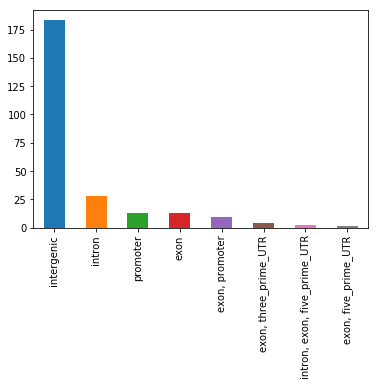

In [635]:
df.annotation.value_counts().plot('bar')

In [606]:
#let's have some fun with data

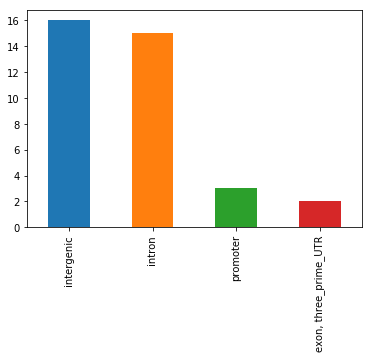

In [636]:
df[df.MITE.notnull()].annotation.value_counts().plot('bar')

In [ ]:
df[(df.MITE.notnull()) & (df.mirbase.notnull())]

In [ ]:
df[df.MITE.notnull()][['Name','MajorRNA','MITE','mirbase']]

In [ ]:
df.to_csv(path_res, sep='\t', index=None)